# Jaws Segmentation Task

Hello, You're tasked with building a neural network using pytorch which segments upper (Maxilla) and lower(Mandible) jaws in a DICOM file

The Dataset is provided as 2D slices from all 3 orthogonal points of view Axial, Coronal, and Sagittal, if you're not familiar with what a DICOM is, you're expected to read online about it

Duration: 1 Week

Deliverables: This notebook (which should contain your solution), and any other files (like saved weights) in a **zip** file, and you mail this **zip** file to us

In [1]:
import boto3
import os
import pathlib
import ipywidgets
from IPython.display import display
from math import ceil
import torch
import gzip
import numpy as np
import glob
import matplotlib.pyplot as plt
from torchvision import transforms
import numpy as np



In [2]:
BUCKET = 'cvml-datasets'
BUCKET_DATASET_PATH = 'jaws-segmentation/v1/public/2d'
LOCAL_DATASET_PATH = 'dataset_trial'
BATCH_SIZE=8

## Downloading Dataset

In this part we download the publically available dataset, you can skip it if you already have it, it should be 512 MB worth of data

In [3]:
from botocore import UNSIGNED
from botocore.client import Config

In [4]:
def download_file(s3client, obj, to):
	key = obj['Key']
	filename = pathlib.Path(to).joinpath(*key.rsplit('/'))
	os.makedirs(filename.parent, exist_ok = True)
	s3client.download_file(Bucket=BUCKET, Key=key, Filename=str(filename))

def download_data(to=LOCAL_DATASET_PATH):
    
    #since our dataset is open-source , we can use unsigned signature version
    
	s3client = boto3.client('s3', config=Config(signature_version=UNSIGNED))
	paginator = s3client.get_paginator('list_objects')
	page_iterator = paginator.paginate(Bucket=BUCKET, Prefix=BUCKET_DATASET_PATH)
	page_counter = 3
	for page in page_iterator:
		progress_bar = ipywidgets.IntProgress(min=0, max=len(page['Contents']), description=f'Page {page_counter}:')
		display(progress_bar)
		file_counter = 0
		for obj in page['Contents']:
			key = obj['Key']
			filename = pathlib.Path(to).joinpath(*key.rsplit('/'))
			os.makedirs(filename.parent, exist_ok = True)
			s3client.download_file(Bucket=BUCKET, Key=key, Filename=str(filename))
			progress_bar.value += 1
		page_counter += 1
#download_data()

## Explore The Dataset

In this section you should explore/plot the dataset and get familiar with it, we are nice enough to write a dataset loader for you and we did some initial visualization for you

In [5]:
class JawsDataset(torch.utils.data.Dataset):
	def __init__(self, dicom_file_list, transforms):
		self.dicom_file_list = dicom_file_list
		self.transforms = transforms

	def __len__(self):
		return len(self.dicom_file_list)

	def __getitem__(self, idx):
		dicom_path = self.dicom_file_list[idx]
		label_path = dicom_path.replace('.dicom.npy.gz', '.label.npy.gz')
		dicom_file = gzip.GzipFile(dicom_path, 'rb')
		dicom = np.load(dicom_file)
		label_file = gzip.GzipFile(label_path, 'rb')
		label = np.load(label_file)
		return self.transforms(dicom), self.transforms(label)

def axial_dataset_train(transforms, validation_ratio = 0.1):
	files = glob.glob('dataset_trial/jaws-segmentation/v1/public/2d/axial/train/**/*.dicom.npy.gz')
	assert len(files) > 0
	validation_files_count = ceil(len(files) * validation_ratio)

	return (JawsDataset(files[validation_files_count:], transforms),
			JawsDataset(files[:validation_files_count], transforms))

def coronal_dataset_train(transforms, validation_ratio = 0.1):
	files = glob.glob('dataset_trial/jaws-segmentation/v1/public/2d/coronal/train/**/*.dicom.npy.gz')
	assert len(files) > 0
	validation_files_count = ceil(len(files) * validation_ratio)

	return (JawsDataset(files[validation_files_count:], transforms),
			JawsDataset(files[:validation_files_count], transforms))

def sagittal_dataset_train(transforms, validation_ratio = 0.1):
	files = glob.glob('dataset_trial/jaws-segmentation/v1/public/2d/sagittal/train/**/*.dicom.npy.gz')
	assert len(files) > 0
	assert len(files) > 0
	validation_files_count = ceil(len(files) * validation_ratio)

	return (JawsDataset(files[validation_files_count:], transforms),
			JawsDataset(files[:validation_files_count], transforms))

def axial_dataset_test(transforms):
	files = glob.glob('dataset_trial/jaws-segmentation/v1/public/2d/axial/test/**/*.dicom.npy.gz')
	assert len(files) > 0
	return JawsDataset(files, transforms)

def coronal_dataset_test(transforms):
	files = glob.glob('dataset_trial/jaws-segmentation/v1/public/2d/coronal/test/**/*.dicom.npy.gz')
	assert len(files) > 0
	return JawsDataset(files, transforms)

def sagittal_dataset_test(transforms):
	files = glob.glob('dataset_trial/jaws-segmentation/v1/public/2d/sagittal/test/**/*.dicom.npy.gz')
	assert len(files) > 0
	return JawsDataset(files, transforms)


In [6]:
#decreasing the size of the input tensor due to limited computational power

dataset_transforms = transforms.Compose([transforms.ToTensor(), transforms.Resize((32, 32))])  #,transforms.Normalize(mean=[0,0,0], std=[1,1,1]) ])

## Note :
* after exploring  labels dataset it looks like that this is a multi classification segmentation where :
   * 1 : is for upper arch
   * 2 : is for lower arch
   * 0 : is for anything else   

# preprocessing ans some helper functions

### Images Normalization and Scaling
* Normalizing Images : since dicom images are in 12 or 16 bits format ,and have pixel values  - in practice -  from ~ ( - 2000 to 4000 ) , we may need to normalize them to be in the normal grey scale of 8 bits range(256 grey shades) -[source]() . 
* Because we are working with bone window images , I expected that WW and WL are ~(2000 , 600) 
* windowing cut-off values  would be ... ( WL ± WW )/2


In [7]:
# defining a function to  normalize the images
def normalize(x):
    ''' takes in an image x and returns that image scaled
       with a feature range of pixel values from 0 to 255. 
       '''
    
    for i in range(x.shape[0]):
        cop=x
#        print (x.shape[0])
#        print (torch.max (x[i][j]))
        
        cop[i][0] = ( cop[i][0] / float(torch.max (cop[i][0])) * (255))
                   
    return cop





# a function that eliminate pixel values that are not needed and may affect our model accuaracy...after that we will convert our training images to 8 bits format
#  we will replace values less than 0 ( air and fats) and values more than 2000 (very hard metals that couse artifacts)

def cutoff(img):# the input is expected to be a bath (ex. (8,1,32,32))    
    for i in range(img.shape[0]):
        j=0
        cop=img
        for x in range(32):
            for y in range(32):
                if cop[i][j][x][y] < 0.0:
                    cop[i][j][x][y] = 0.0
                    #print (cop[i][j][x][y])

                elif cop[i][j][x][y] > 2000. :
                    cop[i][j][x][y] =2000.
                    #print (cop[i][j][x][y])
    return cop





#testing normalize and cutff functions on a test tensor scaled from 0 to 2000
x = (2000-1)*torch.randn(size=(8, 1,32, 32))-1
#print (x)
#cutoff(x) 





In [8]:
# a function that display a bathch of images 
def imgs_display(ima):
    plt.figure(figsize=(20, 9))
    for index in range(0, min(8, len(ima))):
        plt.subplot(2, 4, index + 1)
        plt.axis('off')
        plt.imshow(ima[index].numpy().squeeze(), cmap='bone')

In [9]:
# making a function for better zoomed visualization of images

def image_visualizer(image):
    img = np.squeeze(image)

    fig = plt.figure(figsize = (20,15)) 
    ax = fig.add_subplot(111)
    ax.imshow(img, cmap='gray')
    
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(height):
        for y in range(width):
            #rounding pixel value for only better visualization
            val =img[x][y].item()#,4) if img[x][y] !=0 else 0
            #print (val)

            val=int(val)
            ax.annotate(str(val), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',color='white' if img[x][y]<thresh else 'black')
            

# post processing on model outputs

In [10]:
# defining a function to  normalize output images from the model
# will be used at the end of the notebook
def post_normalize(x):
    ''' takes in an image x and returns that image scaled
       with a feature range of pixel values from 0 to 1. 
       '''
    
    for i in range(x.shape[0]):
        cop=x
#        print (x.shape[0])
#        print (torch.max (x[i][j]))
        
        cop[i][0] = ( cop[i][0] / float(torch.max (cop[i][0])) )*2.0
                   
    return cop





# a function that eliminate pixel values that are not needed and may affect our model accuaracy...after that we will convert our training images to 8 bits format
#  we will replace values less than 0 ( air and fats) and values more than 2000 (very hard metals that couse artifacts)

def post_cutoff(img):# the input is expected to be a bath (ex. (8,1,32,32))    
    for i in range(img.shape[0]):
        j=0
        cop=img
        for x in range(32):
            for y in range(32):
                if cop[i][j][x][y] < 0.0:
                    cop[i][j][x][y] = 0.0
                    #print (cop[i][j][x][y])

                elif cop[i][j][x][y] > 2 :
                    cop[i][j][x][y] =2
                    #print (cop[i][j][x][y])
    return cop





#testing normalize and cutff functions on a test tensor scaled from 0 to 2000
x = (2000-1)*torch.randn(size=(8, 1,32, 32))-1
#print (x)
#cutoff(x) 
def post_visualizer(image):
    img = np.squeeze(image)

    fig = plt.figure(figsize = (20,15)) 
    ax = fig.add_subplot(111)
    ax.imshow(img, cmap='gray', vmin=0.0, vmax=2.000 )
    
    width, height = img.shape
    thresh = 2.0 #max label pixel value
    for x in range(height):
        for y in range(width):
            #rounding pixel value for only better visualization
            val =img[x][y].item()#,4) if img[x][y] !=0 else 0
            #print (val)

            val="{:.2f}".format(val)
            ax.annotate(str(val), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',color='white' if 0.0<img[x][y]<thresh else 'black')
                        

## Preparing dataset loaders

In [11]:
axial_train_dataset, axial_validatiaon_dataset = axial_dataset_train(dataset_transforms)
coronal_train_dataset, coronal_validation_dataset = coronal_dataset_train(dataset_transforms)
sagittal_train_dataset, sagittal_validation_dataset = sagittal_dataset_train(dataset_transforms)


print(f'axial training dataset: {len(axial_train_dataset)} slice')
print(f'coronal training dataset: {len(coronal_train_dataset)} slice')
print(f'sagittal training dataset: {len(sagittal_train_dataset)} slice')


##########################
# adding validation loaders
################################

axial_train_loader = torch.utils.data.DataLoader(axial_validatiaon_dataset, shuffle=True, batch_size=BATCH_SIZE,)
axial_validate_loader = torch.utils.data.DataLoader(axial_train_dataset, shuffle=True, batch_size=BATCH_SIZE)


coronal_train_loader = torch.utils.data.DataLoader(coronal_train_dataset, shuffle=True, batch_size=BATCH_SIZE)
coronal_validate_loader = torch.utils.data.DataLoader(coronal_train_dataset, shuffle=True, batch_size=BATCH_SIZE)

sagittal_train_loader = torch.utils.data.DataLoader(sagittal_train_dataset, shuffle=True, batch_size=BATCH_SIZE)
sagittal_validate_loader = torch.utils.data.DataLoader(sagittal_train_dataset, shuffle=True, batch_size=BATCH_SIZE)

axial training dataset: 902 slice
coronal training dataset: 1334 slice
sagittal training dataset: 1347 slice


# Dataset Visualization

## Axial Images

tensor(1420.4255)
tensor(2.)
torch.Size([8, 1, 32, 32])


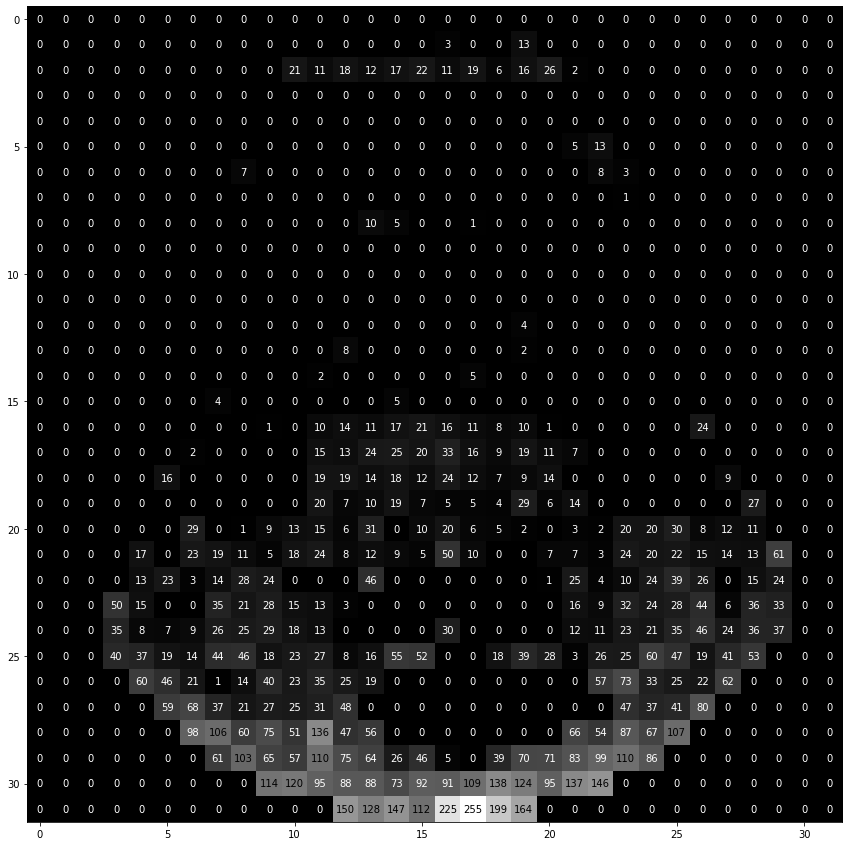

In [155]:
axial_data_iter = iter(axial_train_loader)
images, labels = axial_data_iter.next()

print (torch.max(images[5]))
print (torch.max(labels[5]))
print (images.size()) 


img=images[5]

scaled_batch=normalize(cutoff(images))


image_visualizer(scaled_batch[7])

        
        
#print (cutoff(images) )       

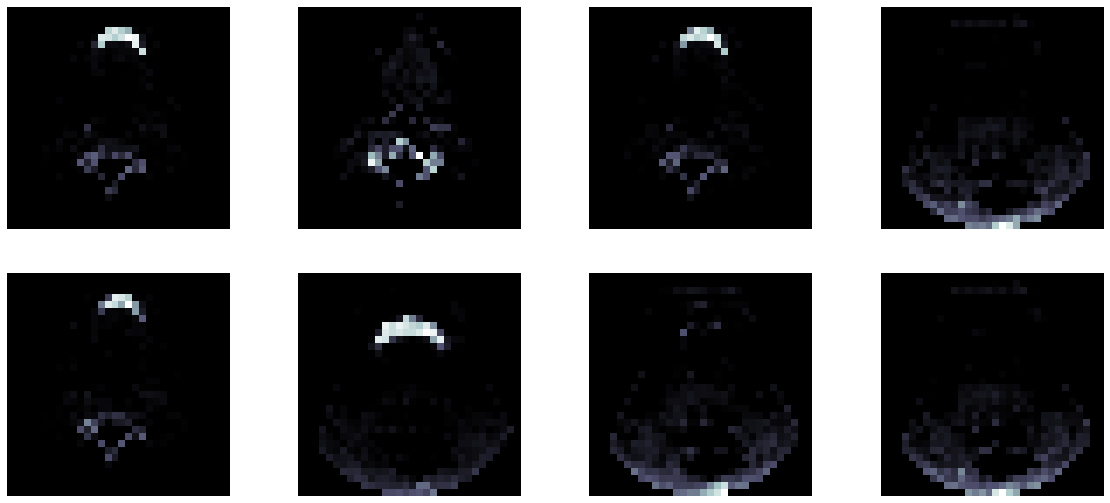

In [156]:
imgs_display(images)

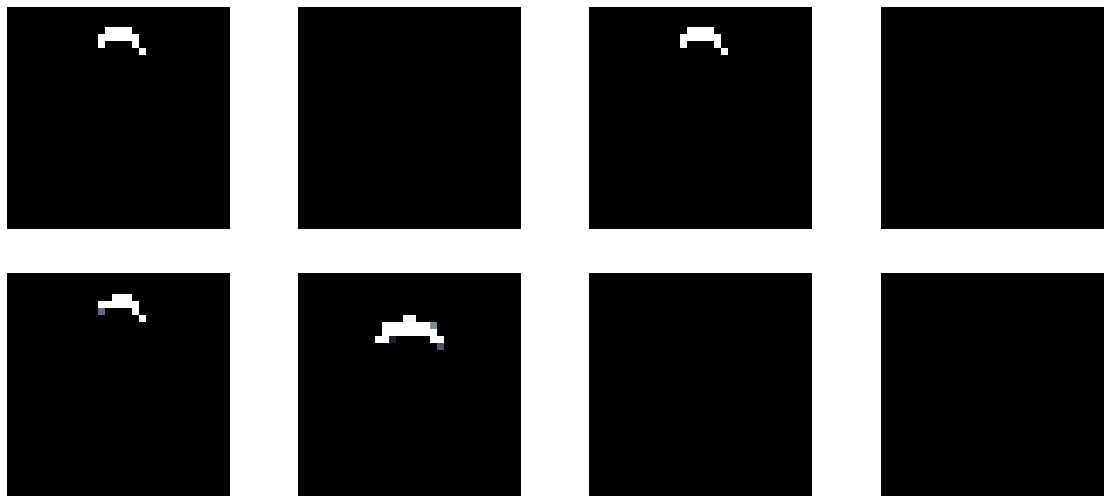

In [157]:
imgs_display(labels)

In [158]:
#sample_image =normalize(cutoff(images))
#print (images)
#sample_image=normalize(cutoff(images))
#print ((sample_image[5]).unique())

#image_visualizer(sample_image[5])
#print (images.dtype) 

## Coronal images

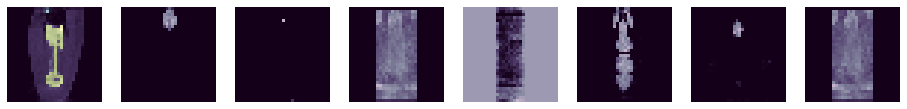

In [159]:
coronal_data_iter = iter(coronal_train_loader)
images, labels = coronal_data_iter.next()
plt.figure(figsize=(16, 4))
for index in range(0, min(16, len(images))):
	plt.subplot(2, 8, index + 1)
	plt.axis('off')
	plt.imshow(images[index].numpy().squeeze(), cmap='bone')
	plt.imshow(labels[index].numpy().squeeze(), alpha=0.3)

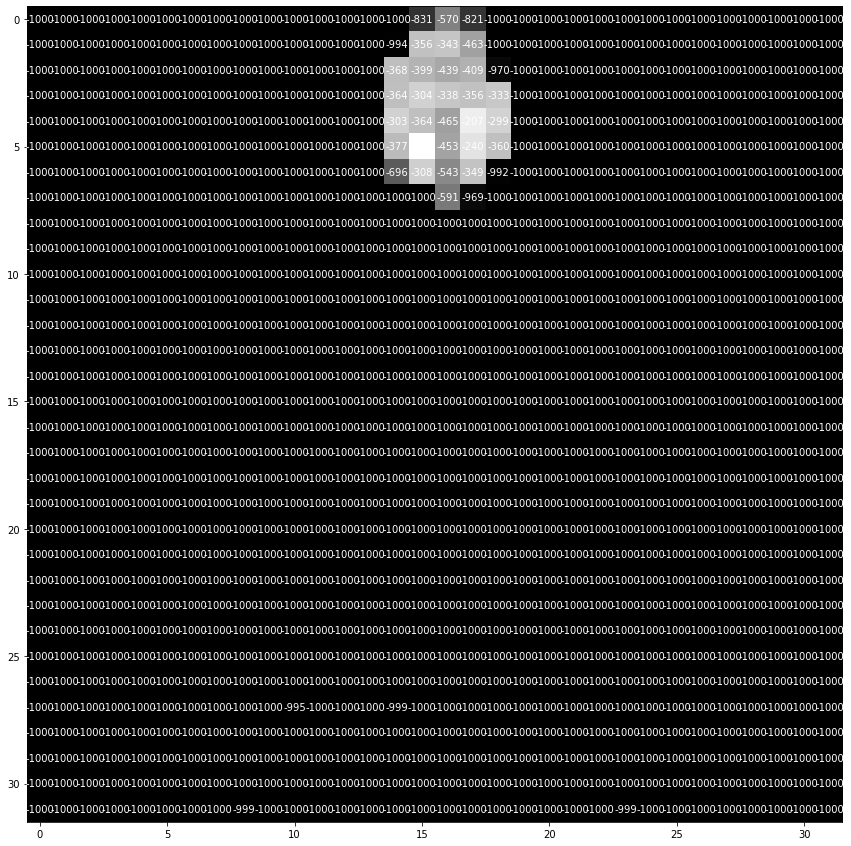

In [160]:
sample_image =images[1]

image_visualizer(sample_image)

# Sagittal Images

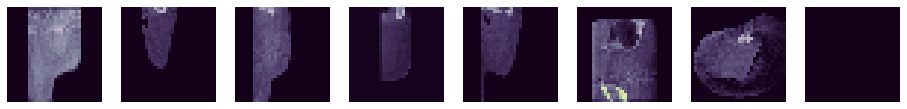

In [161]:
sagittal_data_iter = iter(sagittal_train_loader)
images, labels = sagittal_data_iter.next()
plt.figure(figsize=(16, 4))
for index in range(0, min(16, len(images))):
	plt.subplot(2, 8, index + 1)
	plt.axis('off')
	plt.imshow(images[index].numpy().squeeze(), cmap='bone')
	plt.imshow(labels[index].numpy().squeeze(), alpha=0.3)

# Training

Now that you have downloaded the dataset and inspected it for a bit, you should train your model here, you can train a single model which works with all views (axial, sagittal, coronal), or you can train a model each, it's up to you

# Model stracture 
### I will use UNet for this task as it's commonly used for image segmentations tasks and proved its efficiency


from unet import UNet
model = UNet(in_channels=1,
             out_channels=1,
             n_blocks=3,
             start_filts=16,
             activation='relu',
             normalization='batch',
             conv_mode='same',
             dim=2)



In [12]:
from unet import UNet
model = UNet()
model = UNet(in_channels=1, out_channels=1, n_blocks=4, start_filts=16, activation='relu', normalization='batch', conv_mode='same', dim=2)

print (model.n_blocks)



4


In [13]:
# trying another unet implementation


#from unet_jvanvugt import UNet
#model = UNet()

In [14]:
#initial test of the network
x = torch.randn(size=(8, 1,128, 128), dtype=torch.float32)
with torch.no_grad():
    out = model(x)
    
    
#print (model.padding)
print(f'Out: {out.shape}')




'''
#testing the model on our data set
import torch
criterion = torch.nn.CrossEntropyLoss() 
axial_data_iter = iter(axial_train_loader)
images, labels = axial_data_iter.next()


output = model(images)
loss = criterion(output, labels)

print ('output',(output))
print ('labels',labels)
print ('images',images)

image_visualizer(labels[4])

'''










Out: torch.Size([8, 1, 128, 128])


"\n#testing the model on our data set\nimport torch\ncriterion = torch.nn.CrossEntropyLoss() \naxial_data_iter = iter(axial_train_loader)\nimages, labels = axial_data_iter.next()\n\n\noutput = model(images)\nloss = criterion(output, labels)\n\nprint ('output',(output))\nprint ('labels',labels)\nprint ('images',images)\n\nimage_visualizer(labels[4])\n\n"

In [15]:
#model=UNet()
#print (model.out_channels)
#print (model)

In [16]:
class diceloss(torch.nn.Module):
    def init(self):
        super(diceLoss, self).init()
    def forward(self,pred, target):
       smooth = 1.
       iflat = pred.contiguous().view(-1)
       tflat = target.contiguous().view(-1)
       intersection = (iflat * tflat).sum()
       A_sum = torch.sum(iflat * iflat)
       B_sum = torch.sum(tflat * tflat)
       return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth) )


# Training 

In [17]:
import torch
import numpy as np


# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


In [18]:
import torch.optim as optim

# specify loss function 
# BinaryCrossEntropy  expects probabilities so you should pass your output through a sigmoid.
# BCEWithLogitsLoss() expects logits, so it could be any thing.

criterion =   torch.nn.BCEWithLogitsLoss() # CrossEntropyLoss() #.BCEWithLogitsLoss()   #BCELoss()  #NLLLoss #diceloss()

# specify optimizer (SGD) because 
optimizer = optim.SGD(model.parameters(), lr=0.02)  #SGD   #Adam   

# number of epochs to train the model
n_epochs =30

In [ ]:

val_losses = []
train_losses = []

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
###############################################################################################    
    ###################
    # training the model #
    ###################
    model.train()
    for data, target in axial_train_loader:

        data=normalize(cutoff(data))
        data=data.to(torch.uint8)
        data=data.float()

        
        
        optimizer.zero_grad()
        
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
     
        
#        print ('data' ,data)
#        print ('target' ,target)            
 #       print ('output' ,output)


        # calculate the batch loss
        loss = criterion(output, target)
#        print ('loss',loss.item())

        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        
        # perform a single optimization step (parameter update)
        optimizer.step()
        
        # update training loss
        train_loss += loss
        
#    print (data,target,loss)        
        
# checking the sizes of tensors    
#        print ('input size' ,data.size())
#        print ('target size' ,target.size())
#        print ('output size' ,output.size())
        #print (target)            
        
        
        
    train_losses.append(train_loss.item())    


#    print (data.type())
    #print (data , target,output)
    
########################################################################################## 

    ######################    
    # validation of the model 
    ######################
    model.eval()    
    for data, target in axial_validate_loader:

        # forward pass: compute predicted outputs by passing inputs to the model

        data=normalize(cutoff(data))
        data=data.to(torch.uint8)
        data=data.float()
 
        
        
        output = model(data)

        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        
        valid_loss += loss
        
    val_losses.append(valid_loss.item()) 
    
    
    # calculate average losses
    train_loss = train_loss/len(axial_train_loader.sampler)
    valid_loss = valid_loss/len(axial_validate_loader.sampler)
    
    
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
        torch.save(model.state_dict(), 'Machine_Learning_trial.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.075626 	Validation Loss: 0.064923
Validation loss decreased (inf --> 0.064923).  Saving model ...
Epoch: 2 	Training Loss: 0.055354 	Validation Loss: 0.053007
Validation loss decreased (0.064923 --> 0.053007).  Saving model ...
Epoch: 3 	Training Loss: 0.043102 	Validation Loss: 0.044075
Validation loss decreased (0.053007 --> 0.044075).  Saving model ...
Epoch: 4 	Training Loss: 0.034966 	Validation Loss: 0.036996
Validation loss decreased (0.044075 --> 0.036996).  Saving model ...


## Visualize training using learning curves

In [ ]:
# plotting losses variation during training 

In [ ]:

plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")

plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")

#plt.xticks(range(0.0,1.0))
plt.yticks(range(0,1))

plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()

plt.show()

## Testing

Now you should run your trained model on the test dataset available below and report your results

In [ ]:
#first , getting the model with lowest validation error
model.load_state_dict(torch.load('Machine_Learning_trial.pt'))

In [ ]:
axial_test_dataset = axial_dataset_test(dataset_transforms)
coronal_test_dataset = coronal_dataset_test(dataset_transforms)
sagittal_test_dataset = sagittal_dataset_test(dataset_transforms)


print(f'axial testing dataset: {len(axial_test_dataset)} slice')
print(f'coronal testing dataset: {len(coronal_test_dataset)} slice')
print(f'sagittal testing dataset: {len(sagittal_test_dataset)} slice')

axial_test_loader = torch.utils.data.DataLoader(axial_train_dataset, shuffle=True, batch_size=BATCH_SIZE)
coronal_test_loader = torch.utils.data.DataLoader(coronal_train_dataset, shuffle=True, batch_size=BATCH_SIZE)
sagittal_test_loader = torch.utils.data.DataLoader(sagittal_train_dataset, shuffle=True, batch_size=BATCH_SIZE)

In [ ]:
axial_data_iter = iter(axial_test_loader)
images, labels = axial_data_iter.next()
print (len(axial_test_loader))

In [ ]:
'''
# model testing
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

test_losses=[]
model.eval()
# iterate over test data
for data, target in axial_test_loader:
#    print (data.size())
#    print (target.size())
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss
    #print (output.size())
    test_losses.append( test_loss.item())    

print (output.size())

'''

In [ ]:
#displaying batch of test set
imgs_display(images)

In [ ]:
#output of our network
model.eval()
output=model(images)
imgs_display(output.detach())

In [ ]:
#displaying ground truth of test set
imgs_display(labels)

In [ ]:
tera=output.detach()
#tera=post_normalize(tera)
#print (tera[3])
#post_visualizer(tera[4])

In [ ]:
#image_visualizer(labels[3])

# segmentation accuracy evaluation
*  The two widely used metrics that are used in the case of semantic segmentation, Dice score (F1 score) and Jaccard score (Intersection over Union score). The Dice score is calculated as two times the overlap between the predicted segmentation mask and the Ground Truth mask divided by the total pixels in both the masks. 

### recomended improvements to the model
* extending the model to include tooth segmentation
* trying many loss functions and optimizers

## Defining Dice  loss
* I used this loss because it's widely used in medical images segmentation ref:
* it calculates the similarity between two images
* It's recommended because ....
* cross-entropy loss examines each pixel individually, comparing the class predictions (depth-wise pixel vector) to our one-hot encoded target vector. Because the cross-entropy loss evaluates the class predictions for each pixel vector individually and then averages over all pixels, we are essentially asserting equal learning to each pixel in the image

* dice loss metric is adopted. It is based on the Dice coefficient, which is essentially a measure of overlap between two samples. This measure ranges from 0 to 1 where a Dice coefficient of 1 denotes perfect and complete overlap. Dice loss was originally developed for binary classification, but it can be generalized to work with multiple classes

* The most commonly used loss function for the task of image segmentation is a pixel-wise cross entropy loss. This loss examines each pixel individually, comparing the class predictions (depth-wise pixel vector) to our one-hot encoded target vector.

* Another popular loss function for image segmentation tasks is based on the Dice coefficient, (which you have tried already) which is essentially a measure of overlap between two samples. This measure ranges from 0 to 1 where a Dice coefficient of 1 denotes perfect and complete overlap.

* In case you were wondering, there's a 2 in the numerator in calculating the Dice coefficient because our denominator "double counts" the common elements between the two sets. In order to formulate a loss function which can be minimized, we'll simply use 1−Dice.

* This loss function is known as the soft Dice loss because we directly use the predicted probabilities instead of doing threshold and converting them into a binary mask.